In [1]:
# Downloading data base from kaggle
! pip install kaggle
! mkdir ~/.kaggle
! cp kaggle.json ~/.kaggle/
! chmod 600 ~/.kaggle/kaggle.json
! kaggle competitions download -c birdclef-2022

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
100% 6.10G/6.12G [00:53<00:00, 140MB/s]
100% 6.12G/6.12G [00:53<00:00, 122MB/s]


In [2]:
# Downloadind libraries
! pip install scikit-maad
! sudo apt-get install python-pyaudio python3-pyaudio
! pip install Ipython

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 134 kB 5.1 MB/s 
Reading package lists... Done
Building dependency tree       
Reading state information... Done
The following package was automatically installed and is no longer required:
  libnvidia-common-460
Use 'sudo apt autoremove' to remove it.
The following additional packages will be installed:
  libportaudio2
Suggested packages:
  python-pyaudio-doc
The following NEW packages will be installed:
  libportaudio2 python-pyaudio python3-pyaudio
0 upgraded, 3 newly installed, 0 to remove and 49 not upgraded.
Need to get 113 kB of archives.
After this operation, 432 kB of additional disk space will be used.
Get:1 http://archive.ubuntu.com/ubuntu bionic/universe amd64 libportaudio2 amd64 19.6.0-1 [64.6 kB]
Get:2 http://archive.ubuntu.com/ubuntu bionic/universe amd64 python-pyaudio amd64 0.2.11-1build2 [24.1 kB]
Get:3 http://archive.ubuntu.com/ub

In [3]:
# Libraries
import os
import zipfile as zp
import pickle
import json
import numpy as np
import math

import librosa
import librosa.display
from maad import sound
from maad import util

import matplotlib.pyplot as plt
from google.colab import drive

/usr/local/lib/python3.7/dist-packages/resampy/interpn.py:114: NumbaWarning: The TBB threading layer requires TBB version 2019.5 or later i.e., TBB_INTERFACE_VERSION >= 11005. Found TBB_INTERFACE_VERSION = 9107. The TBB threading layer is disabled.
  _resample_loop_p(x, t_out, interp_win, interp_delta, num_table, scale, y)


In [4]:
# Para facilitar el ejercicio, descomprimimos los archivos
with zp.ZipFile('/content/birdclef-2022.zip', 'r') as zipObj:
   # Extraemos todos los archivos dentro del ambiente de trabajo de google colab
   zipObj.extractall('temp')
   print('File is unzipped in temp folder') 

File is unzipped in temp folder


In [5]:
def save_mfcc(dataset_path, n=5, n_mfcc=128, n_fft=2040,
              hop_length=512, fmin=500, fmax=8500, 
              spec_shape = (48, 128), test_duration = 5
              ):
   
    # Diccionario para archivar los datos
  data = {
      "spp": [],
      "mfcc": []
  }

  # Loop through all the birds sound
  for i,(dirpath,dirnames,filenames) in enumerate(os.walk(dataset_path)):
      
      # Seleccionamos aquellos audios incluidos en el scored_spp
      if dirpath.split('/')[-1] in scored_spp:
          
          # Condicionamos el proceso para especies con muchas muestras
          print("\nProcessing {}".format(dirpath.split("/")[-1]))

          if len(filenames) > n:
            print(f'Too much files: processing only {n}')
          
          # Extracción de los espectrogramas
          try:
            for idx, f in enumerate(filenames): 
              if idx < n:
                
                # Cargamos el archivo de audio
                file_path = os.path.join(dirpath,f)
                signal,sr = librosa.load(file_path)

                # Eliminamos las zonas de silencio
                signal,index = librosa.effects.trim(signal)
                
                # Dividimos el audio en secciones para poder procesar
                stream = list(librosa.stream(file_path,
                      block_length=256,
                      frame_length=4096,
                      hop_length=1024))
                
                for y_block in stream[:-1]:

                  mfcc = librosa.feature.mfcc(y_block,
                                            sr =sr,
                                            n_fft=n_fft,
                                            hop_length=hop_length,
                                            fmin=fmin,
                                            fmax=fmax)
                  

                  rm_bk, noise_profile, _=sound.remove_background(mfcc, gauss_win=100)
                  mfcc = librosa.power_to_db(rm_bk, ref=np.max).astype(np.float32)

                  mfcc = mfcc.T

                  # Normalizamos los valores
                  # mfcc = (mfcc - mfcc.min())/(mfcc.max() - mfcc.min())

                    
                  # mfcc = np.array(mfcc).reshape(-1, 152)          
                  
                  # Guardamos los datos
                  data["mfcc"].append(mfcc.tolist())
                  data["spp"].append(dirpath.split("/")[-1]) 

                print(f'Loading file number {idx}')     
              continue  
          except:
            pass
                    
  return data 

In [ ]:
# Es necesario guardar todas la imágenes en un objeto
dataset_path = '/content/temp/train_audio'

# Sólo los que estamos interesados
scored_spp = open('/content/temp/scored_birds.json')
scored_spp = json.load(scored_spp)

n=5
n_fft=2040 
hop_length=512

data = save_mfcc(dataset_path,
                 n=n,
                 n_fft=n_fft,
                 hop_length=hop_length)

In [ ]:
data['spp']

In [ ]:
# Lo guardamos en el google drive
drive.mount('/content/gdrive') # WARNING! Pedirá permisos

with open('/content/gdrive/MyDrive/Colab Notebooks/mfcc.pickle', 'wb') as file:
    pickle.dump(data, file, protocol=pickle.HIGHEST_PROTOCOL)

Mounted at /content/gdrive


In [7]:
# Librerias
from google.colab import drive
import pickle

import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder

from keras.models import Sequential
from tensorflow.keras.optimizers import Adam
from keras.layers import Dense, Dropout, Conv2D, Flatten, MaxPooling2D, BatchNormalization, LSTM

import matplotlib.pyplot as plt

In [8]:
def plot_history(history):
    """Plots accuracy/loss for training/validation set as a function of the epochs
        :param history: Training history of model
        :return:
    """

    fig, axs = plt.subplots(2, figsize=(15, 15))

    # create accuracy sublpot
    axs[0].plot(history.history["accuracy"], label="train accuracy")
    axs[0].plot(history.history["val_accuracy"], label="test accuracy")
    axs[0].set_ylabel("Accuracy")
    axs[0].legend(loc="lower right")
    axs[0].set_title("Accuracy eval")

    # create error sublpot
    axs[1].plot(history.history["loss"], label="train error")
    axs[1].plot(history.history["val_loss"], label="test error")
    axs[1].set_ylabel("Error")
    axs[1].set_xlabel("Epoch")
    axs[1].legend(loc="upper right")
    axs[1].set_title("Error eval")

    plt.show()

In [9]:
x = np.array(data["mfcc"])

In [10]:
x.shape

(498, 519, 20)

In [11]:
# Label encoder para la variable dependiente
y_encoder = LabelEncoder()
y_encoder.fit(data['spp'])
y = y_encoder.transform(data['spp'])
y

array([ 4,  4,  4,  4,  4,  4,  4,  4,  4,  4,  4,  4,  4,  4,  0,  0,  0,
        0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0, 14, 14,
       14, 14, 14, 14, 14, 14, 14, 14, 14, 14, 14, 14, 14, 14,  5,  5,  5,
        5,  5,  5,  5,  5,  5,  5,  5,  5,  5,  5,  5,  5,  5,  5,  5,  5,
        5,  5,  5,  5,  5,  5,  5,  5,  5,  5,  5,  5,  5,  5,  5,  5, 17,
       17, 17, 17, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15,
       15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15,  6,
        6,  6,  6,  6,  3,  3,  3,  3,  3,  3,  3,  3,  3,  3,  3,  3,  3,
        3,  3,  3,  3,  3,  3,  3,  3,  3, 18, 18, 18, 18, 18, 18, 18, 18,
       18, 18, 18, 18, 18, 18, 18, 18, 18, 18, 18, 18, 18, 18, 18, 18, 18,
       18, 18, 18, 18, 18, 18, 18, 18, 18, 12, 12, 12, 12, 12, 12, 12, 12,
       12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12,
       12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 16, 16,
       16, 16, 16, 16, 16

In [12]:
# Creamos train, validation and test split
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.20, random_state = 1234567)
x_train, x_validation, y_train, y_validation = train_test_split(x_train, y_train, test_size=0.15, random_state = 1234567)
print(f'x_train shape: {x_train.shape}')

x_train shape: (338, 519, 20)


In [13]:
input_shape = (x_train.shape[1], x_train.shape[2]) 
input_shape

# build network topology
model = Sequential()

# 2 LSTM layers
model.add(LSTM(64, input_shape=input_shape, return_sequences=True))
model.add(LSTM(64))
model.add(Dropout(0.1))

# dense layer
model.add(Dense(32, activation='relu'))
model.add(Dropout(0.3))

# output layer
model.add(Dense(32, activation='softmax'))

optimiser = Adam(learning_rate=0.0002)
model.compile(optimizer=optimiser,
              loss = 'sparse_categorical_crossentropy',
              metrics=['accuracy'])

In [15]:
history = model.fit(x_train, y_train, validation_data=(x_validation, y_validation), batch_size = 128, epochs=300)

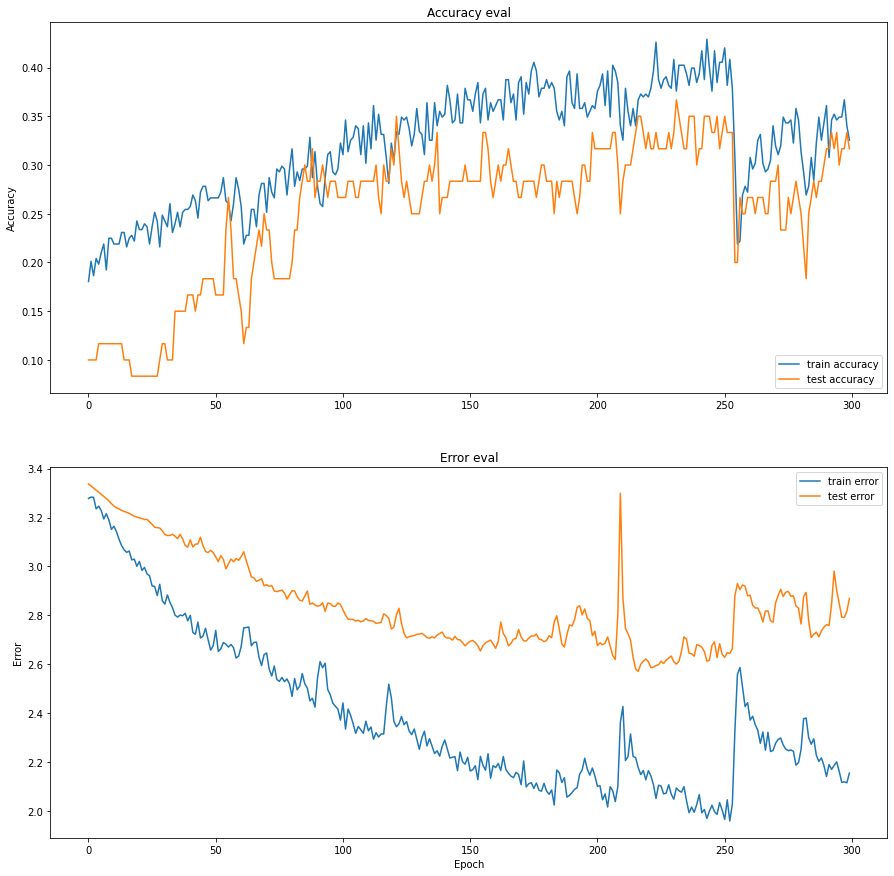

In [16]:
# plot accuracy/error for training and validation
plot_history(history)

In [21]:
# evaluate model on test set
test_loss, test_acc = model.evaluate(x_test, y_test, verbose=2)
print('\nTest accuracy:', test_acc)

4/4 - 0s - loss: 2.4754 - accuracy: 0.3000 - 434ms/epoch - 109ms/step

Test accuracy: 0.30000001192092896


In [ ]:
# Guardamos el modelo en un pickle
pickle.dump(model, open('/content/gdrive/MyDrive/Colab Notebooks/LSTM_model.pickle','wb'))

INFO:tensorflow:Assets written to: ram://40606e6d-c9f2-4b7a-bbb8-df9834dc6640/assets


INFO:tensorflow:Assets written to: ram://40606e6d-c9f2-4b7a-bbb8-df9834dc6640/assets


In [26]:
def save_mfcc_test(dataset_path,n=5, n_mfcc=128, n_fft=2040,
              hop_length=512, fmin=500, fmax=8500):
   
    # Diccionario para archivar los datos
  data = []
  # Loop through all the birds sound
  for i,(dirpath,dirnames,filenames) in enumerate(os.walk(dataset_path)):

    for idx, f in enumerate(filenames):
             
      # Cargamos el archivo de audio
      file_path = os.path.join(dirpath,f)
      signal,sr = librosa.load(file_path)

      # Eliminamos las zonas de silencio
      signal,index = librosa.effects.trim(signal)
      
      # Dividimos el audio en secciones para poder procesar
      stream = list(librosa.stream(file_path,
            block_length=256,
            frame_length=4096,
            hop_length=1024))
      
      for y_block in stream[:-1]:

        mfcc = librosa.feature.mfcc(y_block,
                                  sr =sr,
                                  n_fft=n_fft,
                                  hop_length=hop_length,
                                  fmin=fmin,
                                  fmax=fmax)
        

        rm_bk, noise_profile, _=sound.remove_background(mfcc, gauss_win=100)
        mfcc = librosa.power_to_db(rm_bk, ref=np.max).astype(np.float32)

        mfcc = mfcc.T

        # Guardamos los datos
        data.append(mfcc.tolist())
      print(f'Loading file number {idx}')
  data = np.array(data)
  return data 

In [30]:
# Miramos a ver qué resultado da con el audio test
file_path = '/content/temp/train_audio/hawhaw'

n=5
n_mfcc=128
n_fft=2040 
hop_length=512

test_data = save_mfcc_test(file_path,
                 n=n,
                 n_mfcc=n_mfcc,
                 n_fft=n_fft,
                 hop_length=hop_length)

Loading file number 0
Loading file number 1
Loading file number 2


In [31]:
# perform prediction
prediction = model.predict(test_data)

# get index with max value
predicted_index = np.argmax(prediction, axis=1)

y = y_encoder.inverse_transform(predicted_index)

print("Predicted label: {}".format(y))
# Muy malo no predice lo que toca

Predicted label: ['hawhaw' 'hawhaw' 'hawhaw' 'hawhaw' 'hawhaw' 'hawhaw' 'hawhaw' 'hawhaw'
 'hawhaw' 'hawhaw' 'hawhaw' 'hawhaw' 'hawhaw' 'hawhaw' 'hawhaw' 'hawhaw'
 'hawhaw' 'hawhaw' 'hawhaw' 'hawhaw' 'hawhaw' 'hawhaw' 'hawhaw' 'hawhaw'
 'hawhaw' 'hawhaw' 'hawhaw' 'hawhaw' 'hawhaw' 'hawhaw' 'hawhaw' 'hawcre']
